In [2]:
from postgres import Postgres

pg = Postgres()

results = pg.query(
    """
 SELECT 
	cmetadata->'text' as text
    FROM langchain_pg_embedding 
	WHERE cmetadata @> '{"chunker": "sherpa"}' 
    AND LENGTH(cmetadata->>'sections'::TEXT) > 20
	LIMIT 5000;
                   
	"""
)
documents = [r[0] for r in results]

In [3]:
import spacy

import numpy as np

# Load the spaCy model
nlp = spacy.load("en_core_web_sm")


def remove_place_names_and_stop_words(text):

    custom_phrases = [
        "Abberley",
        "Abbots Langley",
        "Aberford",
        "Ab Kettleby Parish",
        "Acle",
        "Acton",
        "Addingham",
        "Adel",
        "Alcester",
        "Alfold",
        "Cleobury Mortimer",
        "Corby Glen",
        "Cossington",
        "Elmswell",
        "Fulbourn",
        "Nether Whitacre",
        "Sawtry",
        "Strensall & Towthorpe",
        "The Three Parishes",
        "Totnes",
        "West Wittering",
        "Whaley Bridge",
        "Winchfield",
        "Winkfield",
    ]

    doc = nlp(text)
    # Remove place names and stop words
    filtered_tokens = [
        token.text for token in doc if token.ent_type_ != "GPE" and not token.is_stop
    ]

    # Reconstruct the filtered text
    filtered_text = " ".join(filtered_tokens)

    # Remove custom stop phrases (case insensitive)
    filtered_text_lower = filtered_text.lower()
    for phrase in custom_phrases:
        filtered_text_lower = filtered_text_lower.replace(phrase.lower(), "")

    # Split and join to remove extra spaces
    filtered_text = " ".join(filtered_text_lower.split())

    return filtered_text


processed_documents = [remove_place_names_and_stop_words(doc) for doc in documents]

In [4]:
from bertopic import BERTopic

print(processed_documents[0:50])

# Create a BERTopic model
topic_model = BERTopic()
topics, probabilities = topic_model.fit_transform(processed_documents)

# Print the topics
print(topic_model.get_topic_info())

/Users/jimmy/Projects/neighbourhood-plans-server/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['national policy 9 local policy 11 key stages plan prepared 12 sustainability neighbourhood plan 14', 'geography 16 brief history parish 17 parish today 19', '2.16 . current local plan comprises rivers district core strategy1 , adopted council october 2011 sets key planning policies district . read conjunction development management policies , 20132 , site allocations , 20143 . 2.17 . seeks deliver 4,500 new homes 2001 2026 provide additional 2,378 jobs district . states approximately 60 % housing need delivered key centres housing sites sustainable locations edge existing settlements green belt . 2.18 . settlements neighbourhood plan area designated settlement hierarchy : , key centres , bedmond village . settlements , hunton bridge , considered formal settlement hierarchy .', 'local factors affecting new development 28 policy al1 : location development 31', 'action 1 : scale housing growth : prepare early review neighbourhood plan 34 policy al2 : housing mix 35 policy al3 : deliveri

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    Topic  Count                                       Name  \
0      -1    895             -1_development_plan_local_area   
1       0    221                     0_value_yes_green_area   
2       1    214           1_parking_traffic_transport_road   
3       2    161      2_plan_neighbourhood_council_planning   
4       3    158          3_facilities_community_use_centre   
5       4    107      4_housing_affordable_homes_households   
6       5     95      5_biodiversity_species_wildlife_trees   
7       6     87       6_heritage_assets_historic_buildings   
8       7     66              7_detached_houses_photo_brick   
9       8     40                 8_green_space_spaces_local   
10      9     39               9_sea_planning_plan_policies   
11     10     34                             10_19_11_17_20   
12     11     34           11_school_pupils_primary_schools   
13     12     31   12_design_character_building_development   
14     13     29           13_energy_solar_renewable_ca

In [5]:
from transformers import BertModel, BertTokenizer

model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)


def get_embedding(text):
    inputs = tokenizer(
        text, return_tensors="pt", truncation=True, padding=True, max_length=512
    )
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()


embeddings = [get_embedding(doc) for doc in processed_documents]
embeddings = np.vstack(embeddings)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Silhouette Score: 0.05253412947058678


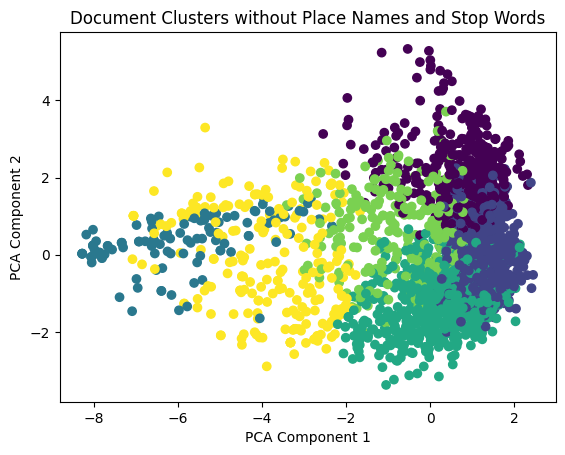

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

num_clusters = 6  # Set the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
clusters = kmeans.fit_predict(embeddings)

# Evaluate
silhouette_avg = silhouette_score(embeddings, clusters)
print(f"Silhouette Score: {silhouette_avg}")

# Visualize
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=clusters)
plt.title("Document Clusters without Place Names and Stop Words")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

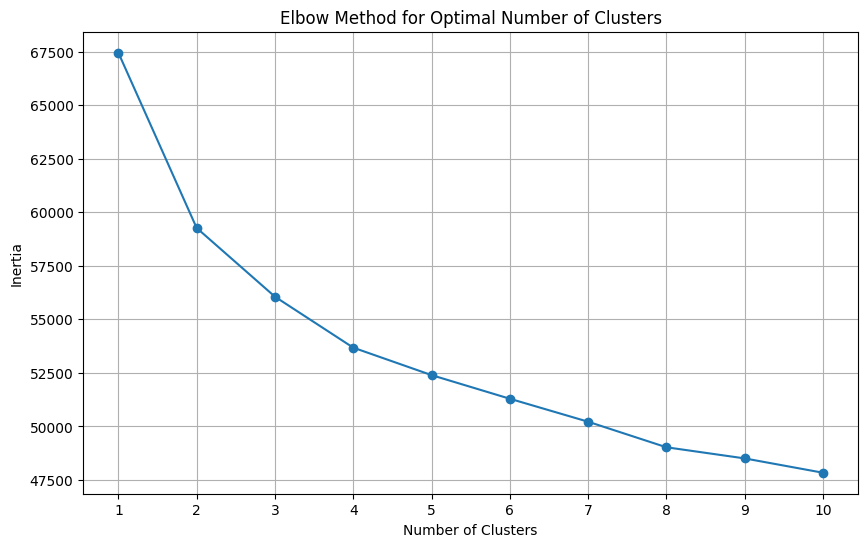

In [7]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assuming embeddings is a numpy array of the document embeddings

# List to store the inertia values for different numbers of clusters
inertia_values = []

# Range of clusters to try
cluster_range = range(1, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(embeddings)
    inertia_values.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia_values, marker="o")
plt.title("Elbow Method for Optimal Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

Estimated number of clusters: 78
Estimated number of noise points: 2556


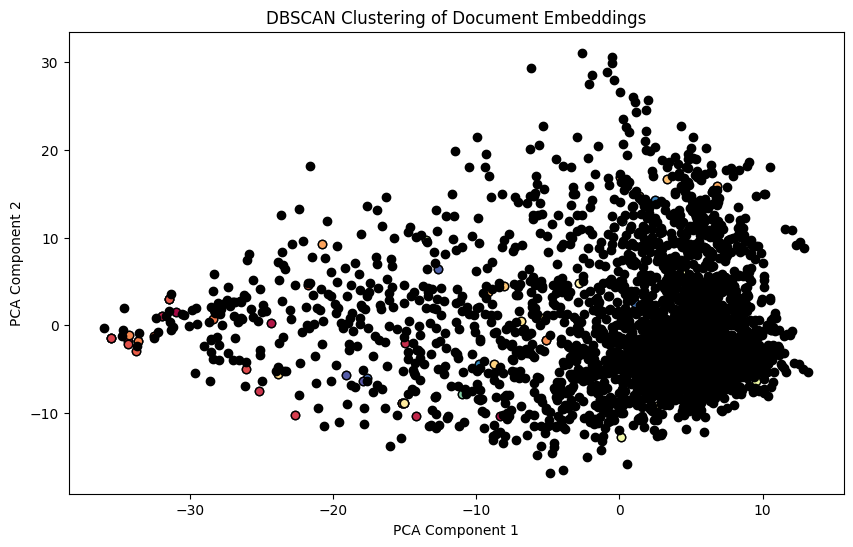

In [9]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Assuming embeddings is a numpy array of the document embeddings

# Standardize the embeddings (DBSCAN works better with standardized data)
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=2)  # Adjust eps and min_samples as needed
clusters = dbscan.fit_predict(embeddings_scaled)

# Number of clusters in labels, ignoring noise if present.
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise = list(clusters).count(-1)

print(f"Estimated number of clusters: {n_clusters}")
print(f"Estimated number of noise points: {n_noise}")

# Visualize the clusters
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings_scaled)

plt.figure(figsize=(10, 6))
unique_labels = set(clusters)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = clusters == k

    xy = reduced_embeddings[class_member_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("DBSCAN Clustering of Document Embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

In [10]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import random

# Standardize the embeddings (DBSCAN works better with standardized data)
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=2)  # Adjust eps and min_samples as needed
clusters = dbscan.fit_predict(embeddings_scaled)

# Number of clusters in labels, ignoring noise if present.
unique_labels = set(clusters)
if -1 in unique_labels:
    unique_labels.remove(-1)  # Remove noise label if present

# Sample 5 examples from each cluster
sampled_examples = {}

for label in unique_labels:
    cluster_indices = np.where(clusters == label)[0]
    if len(cluster_indices) > 0:
        sampled_indices = random.sample(
            list(cluster_indices), min(5, len(cluster_indices))
        )
        sampled_examples[label] = [processed_documents[i]
                                   for i in sampled_indices]

# Print the sampled examples
for label, examples in sampled_examples.items():
    print(f"Cluster {label}:")
    for i, example in enumerate(examples):
        print(f"  Example {i+1}: {example}")
    print("\n")

Cluster 0:
  Example 1: 8
  Example 2: 8


Cluster 1:
  Example 1: h7
  Example 2: h7


Cluster 2:
  Example 1: general land uses possible development sites 2021–2036
  Example 2: general land uses possible development sites 2021–2036


Cluster 3:
  Example 1: cfs4
  Example 2: cfs4


Cluster 4:
  Example 1: h4
  Example 2: h4
  Example 3: h4


Cluster 5:
  Example 1: neighbourhood development plan · version ∙ july 2021
  Example 2: neighbourhood development plan · version ∙ july 2021


Cluster 6:
  Example 1: countryside management & improvement
  Example 2: countryside management & improvement


Cluster 7:
  Example 1: insufficient basis
  Example 2: insufficient basis


Cluster 8:
  Example 1: plan , january 2020
  Example 2: plan , january 2020


Cluster 9:
  Example 1: 1
  Example 2: 1
  Example 3: 1
  Example 4: 1


Cluster 10:
  Example 1: lca 7
  Example 2: lca 7


Cluster 11:
  Example 1: 2
  Example 2: 2


Cluster 12:
  Example 1: 
  Example 2: 
  Example 3: 
  Example 4: 




Cluster 0:
  Example 1:  On the south side of Howard Road is a late twentieth century two storey housing estate that contains a variety of detached, semi-detached and short terraces arranged around a small central grassed area with a small children's playground.
They are constructed in red brick with shallow pitched pantiled roofs and set behind a grass verge with tree and shrub planting.
To the north of Howard Road is a similar housing estate that comprises short terraces laid out in a “Radburn” style with highways and pavements segregated.
They are two storeys in height constructed in brown or buff brick with shallow pitched pantiled roofs (see Photo. 19).
The layout comprises parking courts and garage blocks and pockets of green space with isolated trees.
Rear gardens that overlook streetscene are defined by tall timber fencing or brick walls.   On the south side of Howard Road is a late twentieth century two storey housing estate that contains a variety of detached, semi-detached a

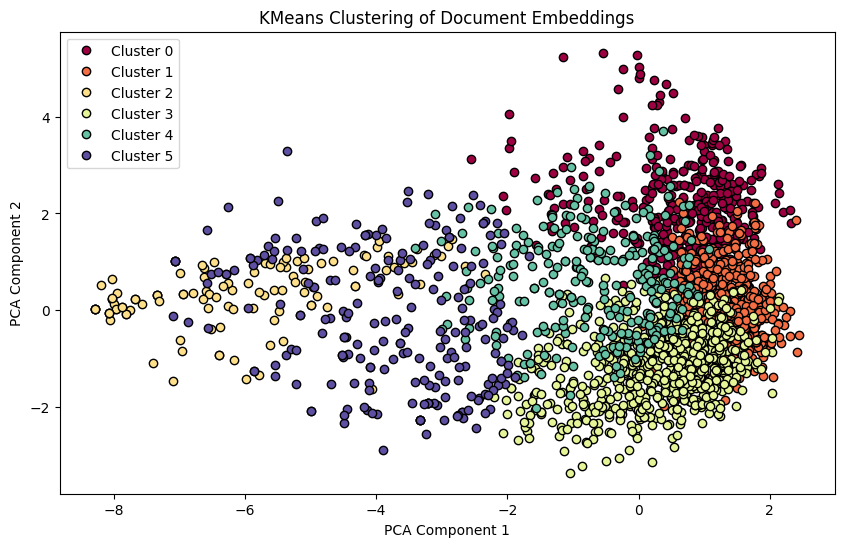

In [11]:
# Perform KMeans clustering
num_clusters = 6  # Set the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
clusters = kmeans.fit_predict(embeddings)

# Sample 5 examples from each cluster
sampled_examples = {}

for label in set(clusters):
    cluster_indices = np.where(clusters == label)[0]
    if len(cluster_indices) > 0:
        sampled_indices = random.sample(
            list(cluster_indices), min(5, len(cluster_indices))
        )
        sampled_examples[label] = [documents[i] for i in sampled_indices]

# Print the sampled examples
for label, examples in sampled_examples.items():
    print(f"Cluster {label}:")
    for i, example in enumerate(examples):
        print(f"  Example {i+1}: {example}")
    print("\n")

# Visualize the clusters
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

plt.figure(figsize=(10, 6))
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, num_clusters)]
for k, col in zip(range(num_clusters), colors):
    class_member_mask = clusters == k
    xy = reduced_embeddings[class_member_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
        label=f"Cluster {k}",
    )

plt.title("KMeans Clustering of Document Embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

In [19]:
from postgres import Postgres

pg = Postgres()

results = pg.query(
    """
 SELECT 
	DISTINCT cmetadata->'neighbourhood' as text
    FROM langchain_pg_embedding 
	WHERE cmetadata @> '{"chunker": "sherpa"}' 
    
	LIMIT 5000;
                   
	"""
)
documents = [r[0] for r in results]

In [20]:
print(documents)

['Abberley', 'Abbots Langley', 'Aberford', 'Ab Kettleby Parish', 'Acle', 'Acton', 'Addingham', 'Adel', 'Alcester', 'Alfold', 'Cleobury Mortimer', 'Corby Glen', 'Cossington', 'Elmswell', 'Fulbourn', 'Nether Whitacre', 'Sawtry', 'Strensall & Towthorpe', 'The Three Parishes', 'Totnes', 'West Wittering', 'Whaley Bridge', 'Winchfield', 'Winkfield']
